In [7]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import data

In [61]:
def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) ":
        return "caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no":
        return "no"
    elif value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "tea"
    elif value == "Alcohol":
        return "alcohol"
    return value

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"])
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})
    

common["drugs"] = common["drugs"].astype('category')

In [56]:
common.dtypes

ts                   datetime64[ns]
user_id                       int64
res_number                    int64
res_reaction                  int64
res_visual                    int64
hungry                     category
sleepy                     category
time_sleep          timedelta64[ns]
time_wake           timedelta64[ns]
stress                     category
fatigue_mental             category
fatigue_physical           category
drugs                      category
dtype: object

### Add times from waking up

In [57]:
common.head()

,ts,user_id,res_number,res_reaction,res_visual,hungry,sleepy,time_sleep,time_wake,stress,fatigue_mental,fatigue_physical,drugs
0,2018-12-18 16:24:13,1,11,297,5119,1,2,00:30:00,07:30:00,1,Yes,"Light activity (walking, cleaning etc.)",caffeine
1,2018-12-19 10:02:27,2,9,561,2219,2,2,01:30:00,09:30:00,3,No,No physical activity,no
2,2018-12-19 10:13:25,3,7,332,13927,1,2,00:00:00,09:25:00,1,No,No physical activity,no
3,2018-12-19 10:31:32,4,9,1085,19,1,1,23:15:00,08:15:00,1,No,"Light activity (walking, cleaning etc.)",no
4,2018-12-19 10:33:30,5,13,299,10476,1,3,01:00:00,06:37:00,3,No,No physical activity,caffeine


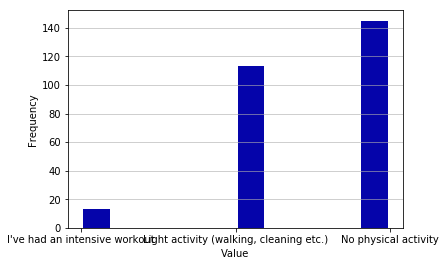

In [76]:
def plot_hist(series):
    n, bins, patches = plt.hist(x=series, bins='auto', color='#0504aa', rwidth=0.85)
    
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plot_hist(common["hungry"])
plot_hist(common["fatigue_physical"])

In [59]:
def plot_reaction_time(rt):
    """
    Plots reaction time 
    :param rt: reaction time Series object
    """
    plt.
    
plot_reaction_time(common["res_reaction"])